Setup the Keras Environment

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import math
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from datasets import load_dataset

In [39]:
ds = load_dataset("pietrolesci/cmnist", "bias_conflicting")

train_splits = [k for k in ds.keys() if k.startswith("train")]
dataset_images = np.concatenate(
    [np.array(ds[split]["pixel_values"]) for split in train_splits],
    axis=0
)
dataset_images = np.transpose(dataset_images, (0, 2, 3, 1))

#select randomly 70% of the data
num_samples = dataset_images.shape[0]
num_train_samples = math.ceil(num_samples * 0.7)
random_indices = np.random.choice(num_samples, num_train_samples, replace=False)
dataset_images = dataset_images[random_indices]

print("Final shape:", dataset_images.shape)

Final shape: (151200, 28, 28, 3)


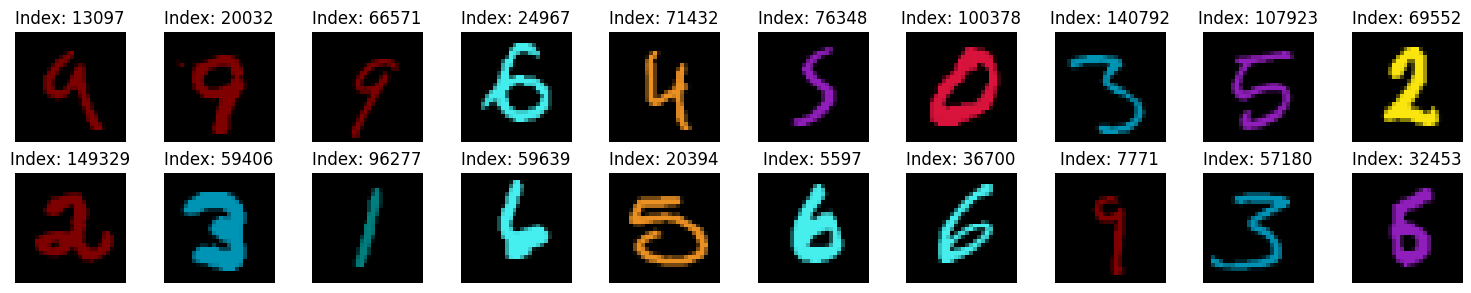

In [40]:
# Select 10 random indices
indices = np.random.choice(len(dataset_images), 20, replace=False)

fig, axes = plt.subplots(2, 10, figsize=(15, 3))
axes = axes.flatten()

for i, idx in enumerate(indices):
    axes[i].imshow(dataset_images[idx])
    axes[i].axis("off")
    axes[i].set_title(f"Index: {idx}")

plt.tight_layout()
plt.show()

Construct the Encoder

In [35]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z = layers.Dense(latent_dim, name="z")(x)
encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

E0000 00:00:1770921241.690008  374043 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1770921241.885078  374043 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 14, 14, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ z (Dense)                       │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,618 (271.95 KB)

 Trainable params: 69,618 (271.95 KB)

 Non-trainable params: 0 (0.00 B)

Construct the Decoder

In [36]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 3)      │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,667 (256.51 KB)

 Trainable params: 65,667 (256.51 KB)

 Non-trainable params: 0 (0.00 B)

Define the AE as a Class with Custom Training

In [37]:
class AE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        #self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            #self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            #"kl_loss": self.kl_loss_tracker.result(),
        }

Train the Model

In [41]:
ae = AE(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam())
history = ae.fit(dataset_images, epochs=30, batch_size=128)

Epoch 1/30


2026-02-12 12:50:42.438092: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1422489600 exceeds 10% of free system memory.


1182/1182 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - loss: 97.3877 - reconstruction_loss: 97.3877
Epoch 2/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 97.2129 - reconstruction_loss: 97.2129
Epoch 3/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 97.1271 - reconstruction_loss: 97.1271
Epoch 4/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 97.0344 - reconstruction_loss: 97.0344
Epoch 5/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 96.8679 - reconstruction_loss: 96.8679
Epoch 6/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 96.8120 - reconstruction_loss: 96.8120
Epoch 7/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 96.7050 - reconstruction_loss: 96.7050
Epoch 8/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 96.6354 - reconstruction_loss: 96.6354
Epoch 9/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - loss: 96.5648 - reconstruction_loss: 96.5648
Epoch 10/30
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 96.4495 - reconstru

In [42]:
print(history.history.keys())

dict_keys(['loss', 'reconstruction_loss'])


Plot the loss function

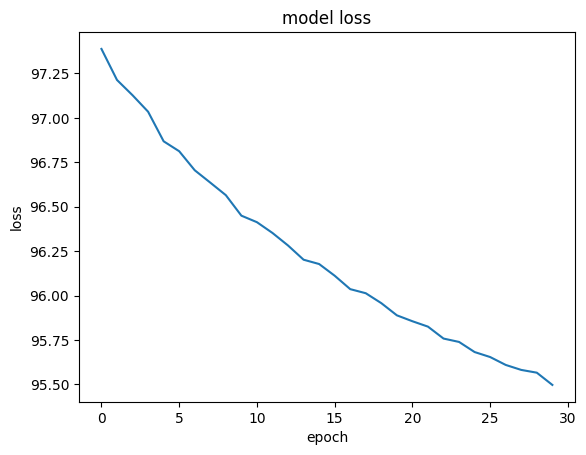

In [52]:
# summarize history for accuracy
plt.plot(history.history['reconstruction_loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()


Save the Model Weights

In [44]:
ae.save_weights('./E4_AE_mnist_latent.weights.h5')

ValueError: You are saving a model that has not yet been built. Try building the model first by calling it on some data or by using `build()`.

Display a grid of sampled digits

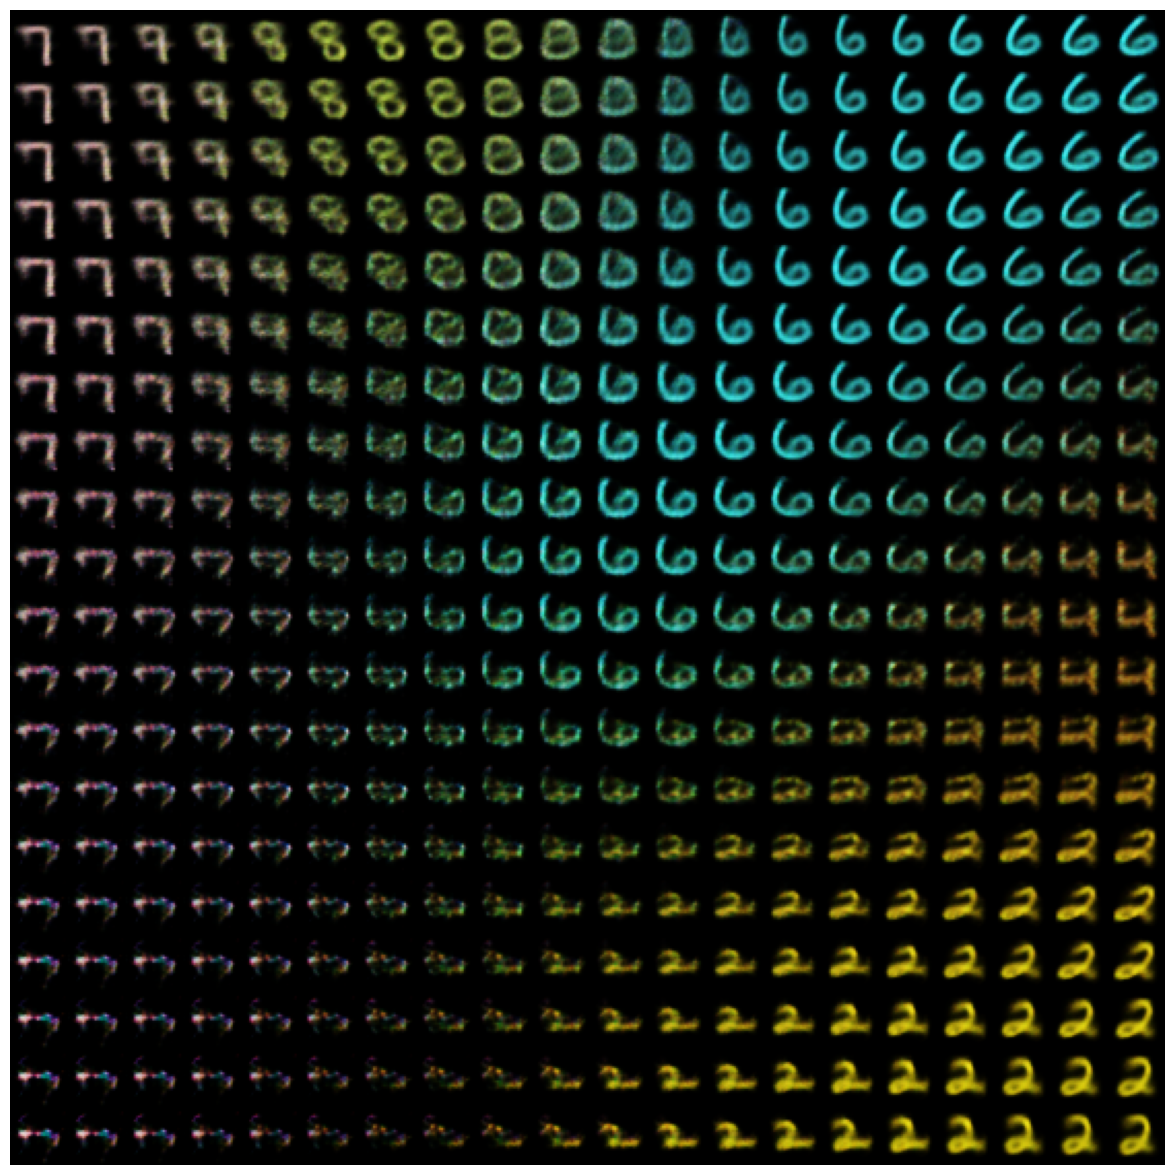

In [48]:
def plot_latent_space(ae, image_shape, n=20, figsize=15):
    """
    image_shape: (H, W, C)
    """

    H, W, C = image_shape
    scale = 1.0

    # Create big canvas
    figure = np.zeros((H * n, W * n, C))

    # Latent grid
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):

            z_sample = np.array([[xi, yi]])
            x_decoded = ae.decoder.predict(z_sample, verbose=0)

            img = x_decoded[0].reshape(H, W, C)

            figure[
                i * H : (i + 1) * H,
                j * W : (j + 1) * W,
                :
            ] = img

    plt.figure(figsize=(figsize, figsize))

    start_range = H // 2
    end_range = n * H + start_range
    pixel_range = np.arange(start_range, end_range, H)

    plt.xticks(pixel_range, np.round(grid_x, 1))
    plt.yticks(pixel_range, np.round(grid_y, 1))

    plt.xlabel("z[0]")
    plt.ylabel("z[1]")

    plt.imshow(figure)   # removed grayscale cmap
    plt.axis("off")
    plt.show()

plot_latent_space(ae, image_shape=(28, 28, 3))

Display how the latent space clusters different digit classes

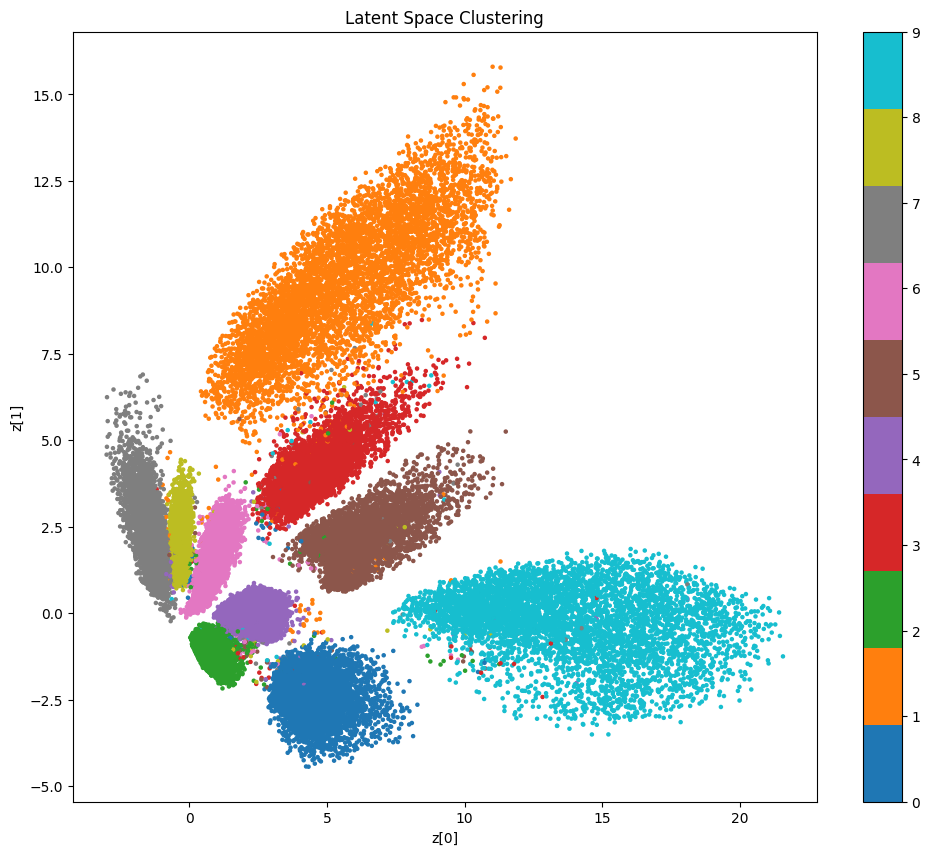

In [51]:
def plot_label_clusters(ae, data, labels):
    # Get latent representation
    z = ae.encoder.predict(data, verbose=0)

    # If encoder returns multiple outputs (e.g., VAE)
    if isinstance(z, list) or isinstance(z, tuple):
        z = z[0]   # take z_mean

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        z[:, 0],
        z[:, 1],
        c=labels,
        cmap="tab10",
        s=5
    )
    plt.colorbar(scatter)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space Clustering")
    plt.show()


split = "train_bc01"

images = np.array(ds[split]["pixel_values"]).astype("float32")
images = np.transpose(images, (0, 2, 3, 1))
labels = np.array(ds[split]["labels"])

plot_label_clusters(ae, images, labels)

# Inpainting

In [ ]:
def mask_image(img, mask_size=12):
    img_masked = img.copy()
    
    H, W, _ = img.shape
    
    # Random top-left corner
    x = np.random.randint(0, H - mask_size)
    y = np.random.randint(0, W - mask_size)
    
    img_masked[x:x+mask_size, y:y+mask_size, :] = 0.0
    
    return img_masked

In [63]:
num_samples = 10
indices = np.random.choice(len(images), num_samples, replace=False)

originals = images[indices]
masked = np.array([mask_image(img, mask_size=10) for img in originals])

reconstructed = ae.decoder.predict(ae.encoder.predict(masked))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


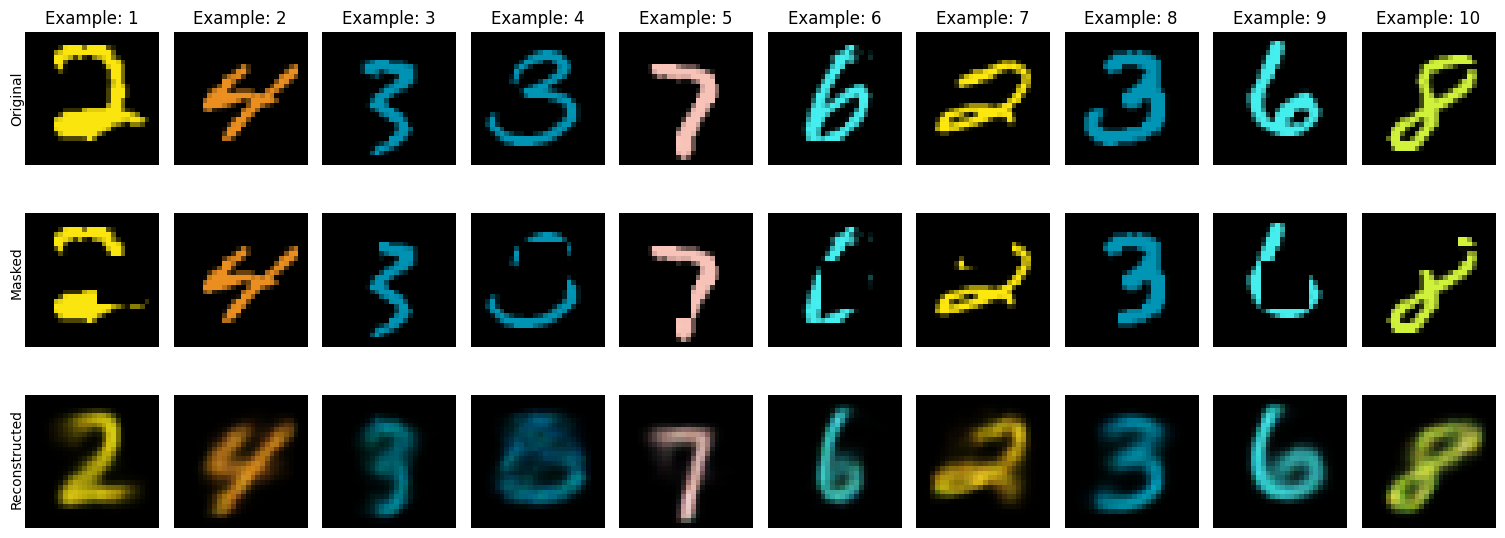

In [94]:
fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))

for i in range(num_samples):
    # Original
    axes[0, i].imshow(originals[i])
    axes[0, i].set_title(f"Example: {i+1}")
    axes[0, i].axis("off")

    # Masked
    axes[1, i].imshow(masked[i])
    axes[1, i].axis("off")

    # Reconstructed
    axes[2, i].imshow(reconstructed[i])
    axes[2, i].axis("off")

fig.text(0.0, 0.8, "Original", va='center', rotation='vertical', fontsize=10)
fig.text(0.0, 0.51, "Masked", va='center', rotation='vertical', fontsize=10)
fig.text(0.0, 0.2, "Reconstructed", va='center', rotation='vertical', fontsize=10)

plt.tight_layout()
plt.show()


# Denoising

In [95]:
split = "test_bc90"

images = np.array(ds[split]["pixel_values"]).astype("float32")
images = np.transpose(images, (0, 2, 3, 1))
labels = np.array(ds[split]["labels"])


In [113]:
def add_gaussian_noise(img, sigma=0.1):
    noise = np.random.normal(0, sigma, img.shape)
    noisy_img = img + noise
    noisy_img = np.clip(noisy_img, 0., 1.)
    return noisy_img

def add_salt_pepper(img, amount=0.05):
    noisy = img.copy()
    num_pixels = int(amount * img.size)

    coords = tuple(np.random.randint(0, i, num_pixels) for i in img.shape)
    noisy[coords] = np.random.choice([0, 1], num_pixels)

    return noisy


def add_noise(img, is_salt_pepper=False):
    noisy = add_gaussian_noise(img)
    if is_salt_pepper:
        noisy = add_salt_pepper(noisy)
    return noisy

In [114]:
num_samples = 10
indices = np.random.choice(len(images), num_samples, replace=False)

originals = images[indices]
selected_labels = labels[indices]

noisy = np.array([add_noise(img, is_salt_pepper=True) for img in originals])

reconstructed = ae.decoder.predict(ae.encoder.predict(noisy))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


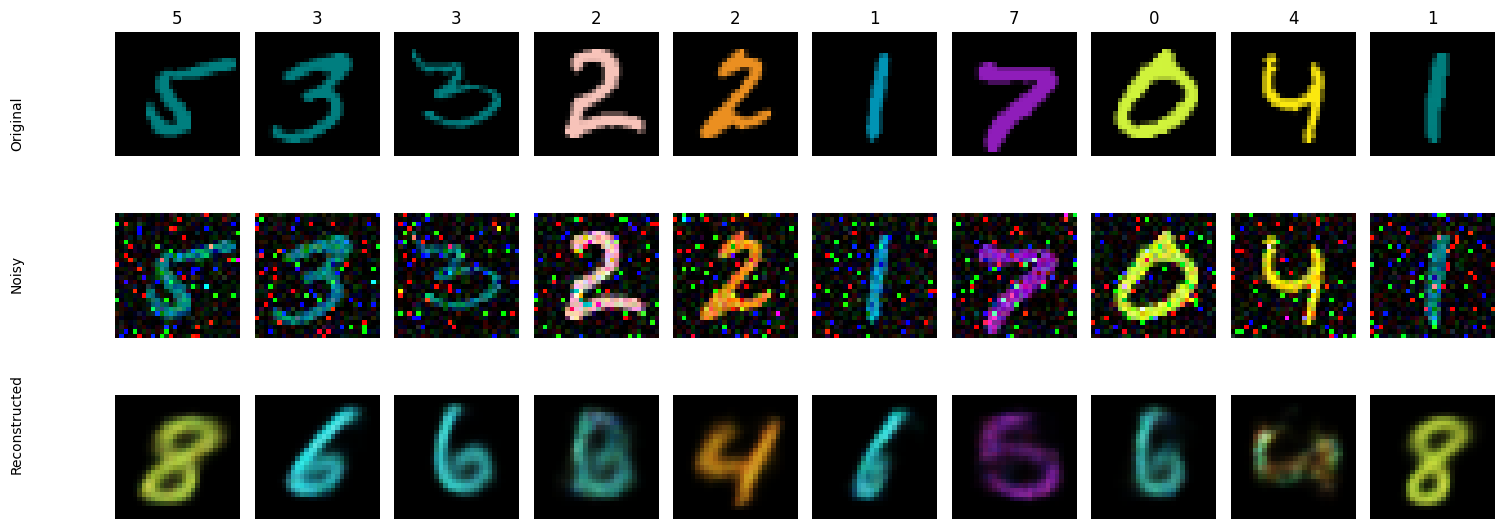

In [115]:
fig, axes = plt.subplots(3, num_samples, figsize=(15, 6))

for i in range(num_samples):
    axes[0, i].imshow(originals[i])
    axes[0, i].set_title(str(selected_labels[i]))
    axes[0, i].axis("off")

    axes[1, i].imshow(noisy[i])
    axes[1, i].axis("off")

    axes[2, i].imshow(reconstructed[i])
    axes[2, i].axis("off")

# Row labels
fig.text(0.0, 0.75, "Original", va='center', rotation='vertical')
fig.text(0.0, 0.50, "Noisy", va='center', rotation='vertical')
fig.text(0.0, 0.25, "Reconstructed", va='center', rotation='vertical')

plt.tight_layout(rect=[0.06, 0, 1, 1])
plt.show()


# Anomali Detection

In [116]:
(x_fashion, _), _ = keras.datasets.fashion_mnist.load_data()

# Convert to 3 channels if your AE expects 3
x_fashion = np.expand_dims(x_fashion, -1)
x_fashion = np.repeat(x_fashion, 3, axis=-1)

x_fashion = x_fashion.astype("float32") / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [117]:
num_samples = 10
indices = np.random.choice(len(x_fashion), num_samples, replace=False)

anomaly_images = x_fashion[indices]


In [118]:
reconstructed = ae.decoder.predict(ae.encoder.predict(anomaly_images))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [119]:
mse = np.mean((anomaly_images - reconstructed) ** 2, axis=(1,2,3))
print("Reconstruction errors:", mse)


Reconstruction errors: [0.07145302 0.14416881 0.3430687  0.04803726 0.22134487 0.19646138
 0.08547966 0.21380556 0.06959523 0.19933254]


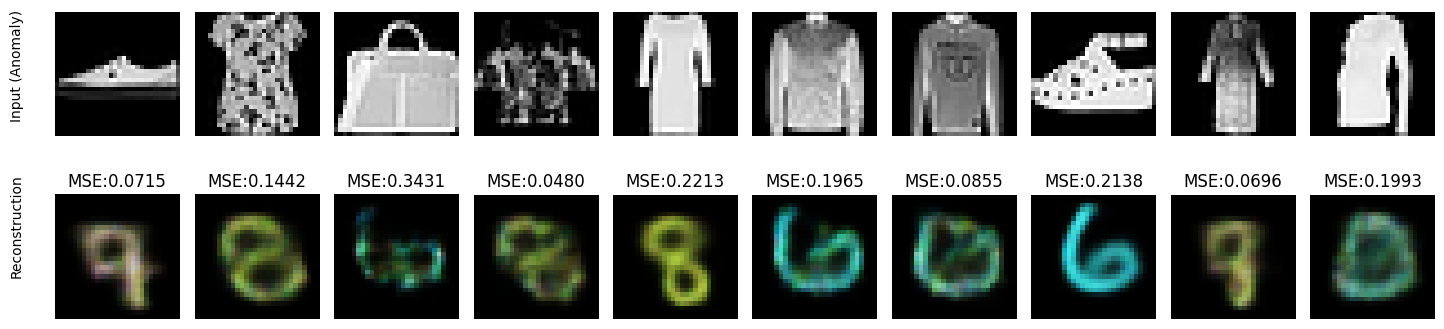

In [120]:
fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

for i in range(num_samples):
    axes[0, i].imshow(anomaly_images[i])
    axes[0, i].axis("off")

    axes[1, i].imshow(reconstructed[i])
    axes[1, i].set_title(f"MSE:{mse[i]:.4f}")
    axes[1, i].axis("off")

fig.text(0.04, 0.75, "Input (Anomaly)", va='center', rotation='vertical')
fig.text(0.04, 0.35, "Reconstruction", va='center', rotation='vertical')

plt.tight_layout(rect=[0.06, 0, 1, 1])
plt.show()


In [123]:
# Normal images
normal = images[:1000]
normal_recon = ae.decoder.predict(ae.encoder.predict(normal))
normal_mse = np.mean((normal - normal_recon)**2, axis=(1,2,3))

# Anomalies
anom_recon = ae.decoder.predict(ae.encoder.predict(anomaly_images))
anom_mse = np.mean((anomaly_images - anom_recon)**2, axis=(1,2,3))

print("Normal mean MSE:", np.mean(normal_mse))
print("Anomaly mean MSE:", np.mean(anom_mse))


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Normal mean MSE: 0.023499321
Anomaly mean MSE: 0.1592747


# Generation

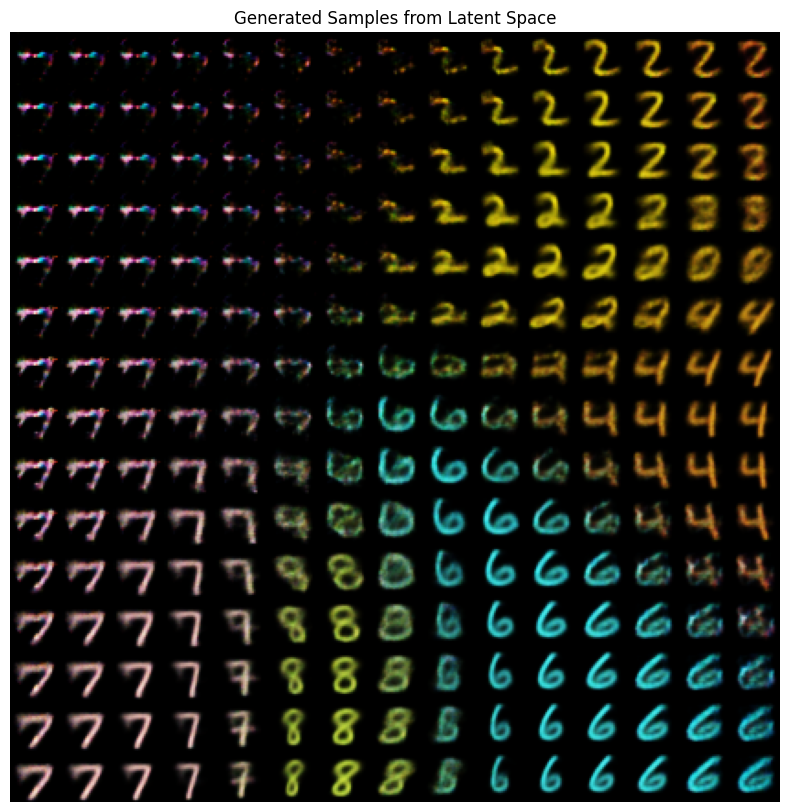

In [124]:
def generate_from_latent(ae, n=10, scale=2.0):
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    H, W, C = ae.decoder.output_shape[1:]

    figure = np.zeros((H*n, W*n, C))

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            decoded = ae.decoder.predict(z_sample, verbose=0)[0]

            figure[
                i*H:(i+1)*H,
                j*W:(j+1)*W,
                :
            ] = decoded

    plt.figure(figsize=(10, 10))
    plt.imshow(figure)
    plt.axis("off")
    plt.title("Generated Samples from Latent Space")
    plt.show()

generate_from_latent(ae, n=15, scale=2)


In [127]:
# Get latent codes of real data
z_real = ae.encoder.predict(images[:5000], verbose=0)

# Sample from real latent distribution
mean = np.mean(z_real, axis=0)
std = np.std(z_real, axis=0)

z_samples = np.random.normal(mean, std, size=(16, latent_dim))
generated = ae.decoder.predict(z_samples, verbose=0)